<h3>Mount Google Drive</h3>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

<h3>Import Modules</h3>

In [2]:
import os
import math
import nibabel
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time

from tensorflow.python.keras.utils.data_utils import Sequence
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K 

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


<h3>Select Modality</h3>

In [3]:
modality_type = "flair"

print("1.{} 2.{} 3.{} 4.{}".format("DWI","Flair","T1","T2"))
x = int(input("Enter modality type:"))
if x==1:
  modality_type = "dwi"
elif x==2:
  modality_type = "flair"
elif x==3:
  modality_type = "t1"
  
elif x==4:
  modality_type = "t2"
else:
  modality_type = "flair"
print("selected modality -> {}".format(modality_type))

1.DWI 2.Flair 3.T1 4.T2
Enter modality type:2
selected modality -> flair


<h3>Extract Dataset</h3>

In [4]:
if modality_type == "dwi":
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/training/dataset_dwi.zip"
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/testing/test_dwi.zip"
elif modality_type == "flair":
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/training/dataset_flair.zip"
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/testing/test_flair.zip"
elif modality_type == "t1":
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/training/dataset_t1.zip"
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/testing/test_t1.zip"
else:
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/training/dataset_t2.zip"
  !unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/testing/test_t2.zip"

Archive:  /content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/training/dataset_flair.zip
   creating: dataset_flair/
   creating: dataset_flair/training/
   creating: dataset_flair/training/flair/
  inflating: dataset_flair/training/flair/aug_0_0_1835.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_2838.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_4486.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_5110.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_6451.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_6617.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_6936.jpg  
  inflating: dataset_flair/training/flair/aug_0_0_7025.jpg  
  inflating: dataset_flair/training/flair/aug_1001_0_1835.jpg  
  inflating: dataset_flair/training/flair/aug_1001_0_2838.jpg  
  inflating: dataset_flair/training/flair/aug_1001_0_4486.jpg  
  inflating: dataset_flair/training/flair/aug_1001_0_5110.jpg  
  inflating: dataset_flair/training/flair/aug_1001_

<h3>Size of Dataset</h3>

In [5]:
num_train_examples = len(os.listdir('dataset_{}/training/mask'.format(modality_type)))
num_val_examples = len(os.listdir('dataset_{}/validation/mask'.format(modality_type)))
num_test_examples = len(os.listdir('test_{}/mask'.format(modality_type)))

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of validation examples: {}".format(num_test_examples))



Number of training examples: 8672
Number of validation examples: 2176
Number of validation examples: 104


<h3>Image Shape , Batch Size , Epochs</h3> 

In [0]:
img_shape = (192, 192, 3)
batch_size = 15
epochs = 100

<h2>Network Architectire</h2>

<h3>1. Encoder Decoder Blocks</h3>

In [0]:
def conv_block(inputs, filters):
    conv11 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn11 = layers.BatchNormalization(axis=3)(conv11)
    a11 = layers.Activation("relu")(bn11)

    #filters-line-conv=2    
    conv21 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn21 = layers.BatchNormalization(axis=3)(conv21)
    a21 = layers.Activation("relu")(bn21)
    conv22 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a21)
    bn22 = layers.BatchNormalization(axis=3)(conv22)
    a22 = layers.Activation("relu")(bn22)

    #filters-line-conv=3
    conv31 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(inputs)
    bn31 = layers.BatchNormalization(axis=3)(conv31)
    a31 = layers.Activation("relu")(bn31)
    conv32 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a31)
    bn32 = layers.BatchNormalization(axis=3)(conv32)
    a32 = layers.Activation("relu")(bn32)
    conv33 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a32)
    bn33 = layers.BatchNormalization(axis=3)(conv33)
    a33 = layers.Activation("relu")(bn33)

    resout = layers.concatenate([a11,a22,a33,inputs])
    resout = layers.Activation("relu")(resout)

    return resout

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
    return pool, encoder
  
def upconv_block(lower_input,higher_input,filters):
    transpose = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(lower_input)
    upconv_concat = layers.concatenate([higher_input, transpose], axis=-1)
    return upconv_concat

def decoder_block(inputs, concat_tensor, filters):
    decoder = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)

    conv11 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(decoder)
    bn11 = layers.BatchNormalization(axis=3)(conv11)
    a11 = layers.Activation("relu")(bn11)

    #filters-line-conv=2    
    conv21 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(decoder)
    bn21 = layers.BatchNormalization(axis=3)(conv21)
    a21 = layers.Activation("relu")(bn21)
    conv22 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a21)
    bn22 = layers.BatchNormalization(axis=3)(conv22)
    a22 = layers.Activation("relu")(bn22)

    #filters-line-conv=3
    conv31 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(decoder)
    bn31 = layers.BatchNormalization(axis=3)(conv31)
    a31 = layers.Activation("relu")(bn31)
    conv32 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a31)
    bn32 = layers.BatchNormalization(axis=3)(conv32)
    a32 = layers.Activation("relu")(bn32)
    conv33 = layers.Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(a32)
    bn33 = layers.BatchNormalization(axis=3)(conv33)
    a33 = layers.Activation("relu")(bn33)

    
    resout = layers.concatenate([a11,a22,a33,decoder])
    resout = layers.Activation("relu")(resout)

    return resout

<h3>2. Network</h3>

<h4>2.1 Initital Finter Size</h4>

In [0]:
#initial filter number
ifn=16

<h4>2.2 Network Layers</h4>

In [9]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, ifn)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 2*ifn)
upconv_concat1 = upconv_block(encoder1,encoder0,ifn)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 4*ifn)
upconv_concat2 = upconv_block(encoder2,encoder1,2*ifn)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 8*ifn)
upconv_concat3 = upconv_block(encoder3,encoder2,4*ifn)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 16*ifn)
upconv_concat4 = upconv_block(encoder4,encoder3,8*ifn)
# 8

center = conv_block(encoder4_pool, 32*ifn)
# center

decoder4 = decoder_block(center, encoder4, 16*ifn)
# 16

decoder3 = decoder_block(decoder4, upconv_concat4, 8*ifn)
# 32

decoder2 = decoder_block(decoder3, upconv_concat3, 4*ifn)
# 64

decoder1 = decoder_block(decoder2, upconv_concat2, 2*ifn)
# 128

decoder0 = decoder_block(decoder1, upconv_concat1, ifn)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = models.Model(inputs=[inputs], outputs=[outputs])
#model.summary()

W0731 06:34:12.560579 140581795157888 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<h3>Evaluation Matrices<h3>

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def specificity(y_true, y_pred):
  neg_y_true = 1 - y_true
  neg_y_pred = 1 - y_pred
  fp = K.sum(neg_y_true * y_pred)
  tn = K.sum(neg_y_true * neg_y_pred)
  specificity = tn / (tn + fp + K.epsilon())
  return specificity

def dsc(y_true, y_pred):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    tp = K.sum(y_true * y_pred)
    fn = K.sum(y_true * neg_y_pred)
    fp = K.sum(neg_y_true * y_pred)
    dsc = (2*tp) / ((2*tp) + fn + fp + K.epsilon())
    return dsc
  
def sensitivity(y_true, y_pred):
  neg_y_true = 1 - y_true
  neg_y_pred = 1 - y_pred
  tp = K.sum(y_true * y_pred)
  fn = K.sum(y_true * neg_y_pred)
  sensitivity = tp / (tp + fn + K.epsilon())
  return sensitivity

def sce(y_true, y_pred):
    loss = tf.losses.sigmoid_cross_entropy(y_true, y_pred)
    return loss
  
def bce(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred)
    return loss

<h3>Compile Model</h3>

In [0]:
model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss,dsc,sensitivity,specificity,'accuracy'])
#model.compile(optimizer='adam', loss=sce, metrics=[dice_loss,dsc,sensitivity,specificity,'accuracy'])

#model.summary()

<h2>Image Data Generator</h2>

<h4>Training Image</h4>

In [0]:
def trainset(b_size):
    seed = 1337
    image_datagen = ImageDataGenerator(rescale=1.0/255)
    mask_datagen = ImageDataGenerator(rescale=1.0/255)

    image = image_datagen.flow_from_directory(
        "dataset_{}/training".format(modality_type),
        classes = [modality_type],
        shuffle=True,
        class_mode=None,
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )


    mask = mask_datagen.flow_from_directory(
       "dataset_{}/training".format(modality_type),
        classes = ['mask'],
        shuffle=True,
        class_mode=None,
        color_mode = "grayscale",
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )
    

    train_data_generator = zip(image,mask)

    for (image,mask) in train_data_generator:
        yield(image-0.5,mask)

train_set = trainset(batch_size)

<h4>Validation Image</h4>

In [0]:
def validset(b_size):
    seed = 1223
    image_datagen = ImageDataGenerator(rescale=1.0/255)
    mask_datagen = ImageDataGenerator(rescale=1.0/255)

    image = image_datagen.flow_from_directory(
        "dataset_{}/validation".format(modality_type),
        classes = [modality_type],
        shuffle=True,
        class_mode=None,
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )


    mask = mask_datagen.flow_from_directory(
       "dataset_{}/validation".format(modality_type),
        classes = ['mask'],
        shuffle=True,
        class_mode=None,
        color_mode = "grayscale",
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )
    

    valid_data_generator = zip(image,mask)

    for (image,mask) in valid_data_generator:
        yield(image-0.5,mask)
valid_set = validset(batch_size)

<h3>Learing Rate Optimizer</h3>

In [0]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))   
    return tf.keras.callbacks.LearningRateScheduler(schedule,verbose=1)
lr = step_decay_schedule(initial_lr=1e-4, decay_factor=0.2, step_size=2)

<h2>Trainig</h2>

<h3>Model name, saving location and callback functions</h3>

In [0]:
model_name = 'unet-{}-model-loss-dice222-batch_size={}-time={}.hdf5'.format(modality_type,int(batch_size),int(time.time()))
save_model_path = '/content/gdrive/My Drive/Colab Notebooks/final/siss/checkpoint/{}/{}'.format(modality_type,model_name)
tb = tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/Colab Notebooks/final/siss/logs/{}/{}'.format(modality_type,model_name))
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=False)

<h3>Train</h3>

In [16]:
#model.load_weights('/content/gdrive/My Drive/Colab Notebooks/final/checkpoint/unet-model-batch_size=3-time=1559301950.hdf5');
history = model.fit_generator(
                   train_set,
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=valid_set,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[tb,cp,es,lr]
                   )

Found 8672 images belonging to 1 classes.
Found 8672 images belonging to 1 classes.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
578/579 [============================>.] - ETA: 0s - loss: 0.5928 - dice_loss: 0.5928 - dsc: 0.4071 - sensitivity: 0.8917 - specificity: 0.8628 - acc: 0.8908Found 2176 images belonging to 1 classes.
Found 2176 images belonging to 1 classes.

Epoch 00001: val_loss improved from inf to 0.34150, saving model to /content/gdrive/My Drive/Colab Notebooks/final/siss/checkpoint/flair/unet-flair-model-loss-dice222-batch_size=15-time=1564554872.hdf5
579/579 [==============================] - 518s 894ms/step - loss: 0.5922 - dice_loss: 0.5922 - dsc: 0.4078 - sensitivity: 0.8915 - specificity: 0.8630 - acc: 0.8908 - val_loss: 0.3415 - val_dice_loss: 0.3415 - val_dsc: 0.6585 - val_sensitivity: 0.8257 - val_specificity: 0.9841 - val_acc: 0.9739

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/100
578/579 [==

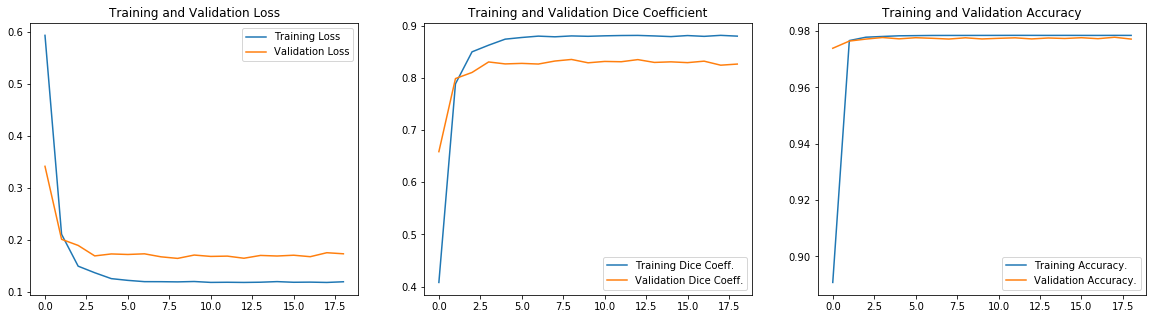

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

dice = history.history['dsc']
val_dice = history.history['val_dsc']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs_range = range(19)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, dice, label='Training Dice Coeff.')
plt.plot(epochs_range, val_dice, label='Validation Dice Coeff.')
plt.legend(loc='best')
plt.title('Training and Validation Dice Coefficient')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, acc, label='Training Accuracy.')
plt.plot(epochs_range, val_acc, label='Validation Accuracy.')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.show()


<h2>Testing</h2>

In [0]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/test_siss.zip"

<h3>1. Image Viewer</h3>

In [0]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

def multi_slice_viewer(volume1,volume2):
    remove_keymap_conflicts({'j', 'k'})
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.index = volume1.shape[0] // (volume1.shape[0]+1)
    ax2.index = volume2.shape[0] // (volume2.shape[0]+1)
    ax1.volume = volume1
    ax2.volume = volume2
    ax1.set_xlabel("Ground Truth ")
    ax2.set_xlabel("Prediction ")
    ax1.imshow(volume1[ax1.index])
    ax2.imshow(volume2[ax2.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax1 = fig.axes[0]
    ax2 = fig.axes[1]
    if event.key == 'j':
        previous_slice(ax1)
        previous_slice(ax2)
    elif event.key == 'k':
        next_slice(ax1)
        next_slice(ax2)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1)  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) 
    ax.images[0].set_array(volume[ax.index])

def showResult():
    true = []
    predict = []

    for i in range(num_test_examples):
        image = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result/image/{}.jpg'.format(i))
        mask = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result/mask/{}.jpg'.format(i))
        predicted = cv2.imread('/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result/predicted/{}.jpg'.format(i))
        masked_image = cv2.addWeighted(image,1,mask,0.6,0)
        predicted_image = cv2.addWeighted(image,1,predicted,0.6,0)
        true.append(image)
        predict.append(predicted)

    x = np.array(true)
    y = np.array(predict)
    print(x.shape)
    multi_slice_viewer(x,y)
    plt.show()

<h3>2. Image Data Generator</h3>

In [0]:
num_test_examples = len(os.listdir('test_flair_3/mask'))

In [0]:
def saveData(image,mask,cnt):
  for i in range(image.shape[0]):
    img_name = '/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result3/image/{}.jpg'.format(str(cnt+i))
    mask_name = '/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result3/mask/{}.jpg'.format(str(cnt+i))
    plt.imsave(img_name,image[i,:,:],cmap='gray')
    plt.imsave(mask_name,mask[i,:,:,0],cmap='gray')

def testset(b_size):
    seed = 1337
    image_datagen = ImageDataGenerator(rescale=1.0/255)
    mask_datagen = ImageDataGenerator(rescale=1.0/255)

    image = image_datagen.flow_from_directory(
        #"test_{}".format(modality_type),
        "test_flair_3",
        #classes = [modality_type],
        classes = ["flair"],
        shuffle=False,
        class_mode=None,
        target_size = (192,192),
        batch_size = b_size,
        seed=seed 
    )

    mask = mask_datagen.flow_from_directory(
        #"test_{}".format(modality_type),
        "test_flair_3",
        classes = ['mask'],
        shuffle=False,
        class_mode=None,
        color_mode = "grayscale",
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )
  
    train_data_generator = zip(image,mask)
    cnt = 0
    for (image,mask) in train_data_generator:
      saveData(image,mask,cnt)
      cnt+=image.shape[0]
      yield(image-0.5,mask)

<h3>3. Test</h3>

In [36]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/final/siss/checkpoint/flair/unet-flair-model-loss-dice-batch_size=15-time=1563387028.hdf5')
test_set = testset(batch_size)
predicted = model.predict_generator(test_set,steps=int(np.ceil(num_test_examples / float(batch_size))), verbose=1)

Found 104 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
7/7 [==============================] - 4s 635ms/step


<h3>4. Saving and Showing Test Result</h3>

In [37]:
print(predicted.shape)
data = np.reshape(predicted,(predicted.shape[0],1,192,192))
print(data.shape)

for i in tqdm(range(data.shape[0])):
    img_name = '/content/gdrive/My Drive/Colab Notebooks/final/siss/test_result3/predicted/{}.jpg'.format(str(i))
    plt.imsave(img_name,data[i][0],cmap='gray')

showResult()

 11%|█         | 11/104 [00:00<00:00, 103.37it/s]

(104, 192, 192, 1)
(104, 1, 192, 192)


100%|██████████| 104/104 [00:00<00:00, 116.60it/s]


error: ignored

<h2>Evaluate</h2>

In [0]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/final/siss/dataset/evaluate.zip"

In [0]:
model.load_weights('/content/gdrive/My Drive/Colab Notebooks/final/siss/checkpoint/flair/unet-flair-model-loss-dice-batch_size=15-time=1563387028.hdf5')

In [40]:
def evaluateset(b_size):
    seed = 1223
    image_datagen = ImageDataGenerator(rescale=1.0/255)
    mask_datagen = ImageDataGenerator(rescale=1.0/255)

    image = image_datagen.flow_from_directory(
        "evaluate/1",
        classes = ['img'],
        shuffle=True,
        class_mode=None,
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )


    mask = mask_datagen.flow_from_directory(
       "evaluate/1",
        classes = ['mask'],
        shuffle=True,
        class_mode=None,
        color_mode = "grayscale",
        target_size = (192,192),
        batch_size = b_size,
        seed=seed
    )
    

    valid_data_generator = zip(image,mask)

    for (image,mask) in valid_data_generator:
        yield(image-0.5,mask)
evaluate_set = evaluateset(batch_size)
model.evaluate_generator(evaluate_set,steps=20,verbose=1)

Found 83 images belonging to 1 classes.
Found 83 images belonging to 1 classes.
20/20 [==============================] - 5s 274ms/step - loss: 0.1177 - dice_loss: 0.1177 - dsc: 0.8823 - sensitivity: 0.8554 - specificity: 0.9960 - acc: 0.9777


[0.11769941747188568, 0.11769941, 0.8822979, 0.8554022, 0.99595785, 0.97774774]